### SSR greedy algorithm
Stepwise sparse regression (SSR) solves the problem by iteratively truncating off the smallest coefficient during the optimization. There are many ways one can decide to truncate terms. We implement two popular ways, truncating the smallest coefficient at each iteration, or chopping each coefficient, computing N - 1 models, and then choosing the model with the lowest residual error. 

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
import pysindy as ps

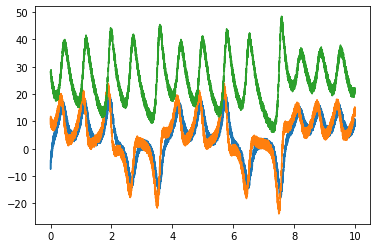

In [2]:
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

dt = .002
t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_train = x_train + np.random.rand(x_train.shape[0], 3) * 4
ssr_optimizer = ps.SSR(alpha=.05)

model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)

for i in range(3):
    plt.plot(t_train, x_train[:, i])

Note the usage is a bit different because we save all the sparse models and we choose our favorite one afterwards. Below we show Model 4 has the lowest MSE between the predicted and true derivative, so we could use this to choose our model. 

Model 0, MSE: 767.590197
Model 1, MSE: 788.993290
Model 2, MSE: 757.203506
Model 3, MSE: 693.153468
Model 4, MSE: 777.368792
Model 5, MSE: 748.044582
Model 6, MSE: 2496.647939
Model 7, MSE: 3663.271610
Model 8, MSE: 3660.263569
Model 9, MSE: 4232.533112


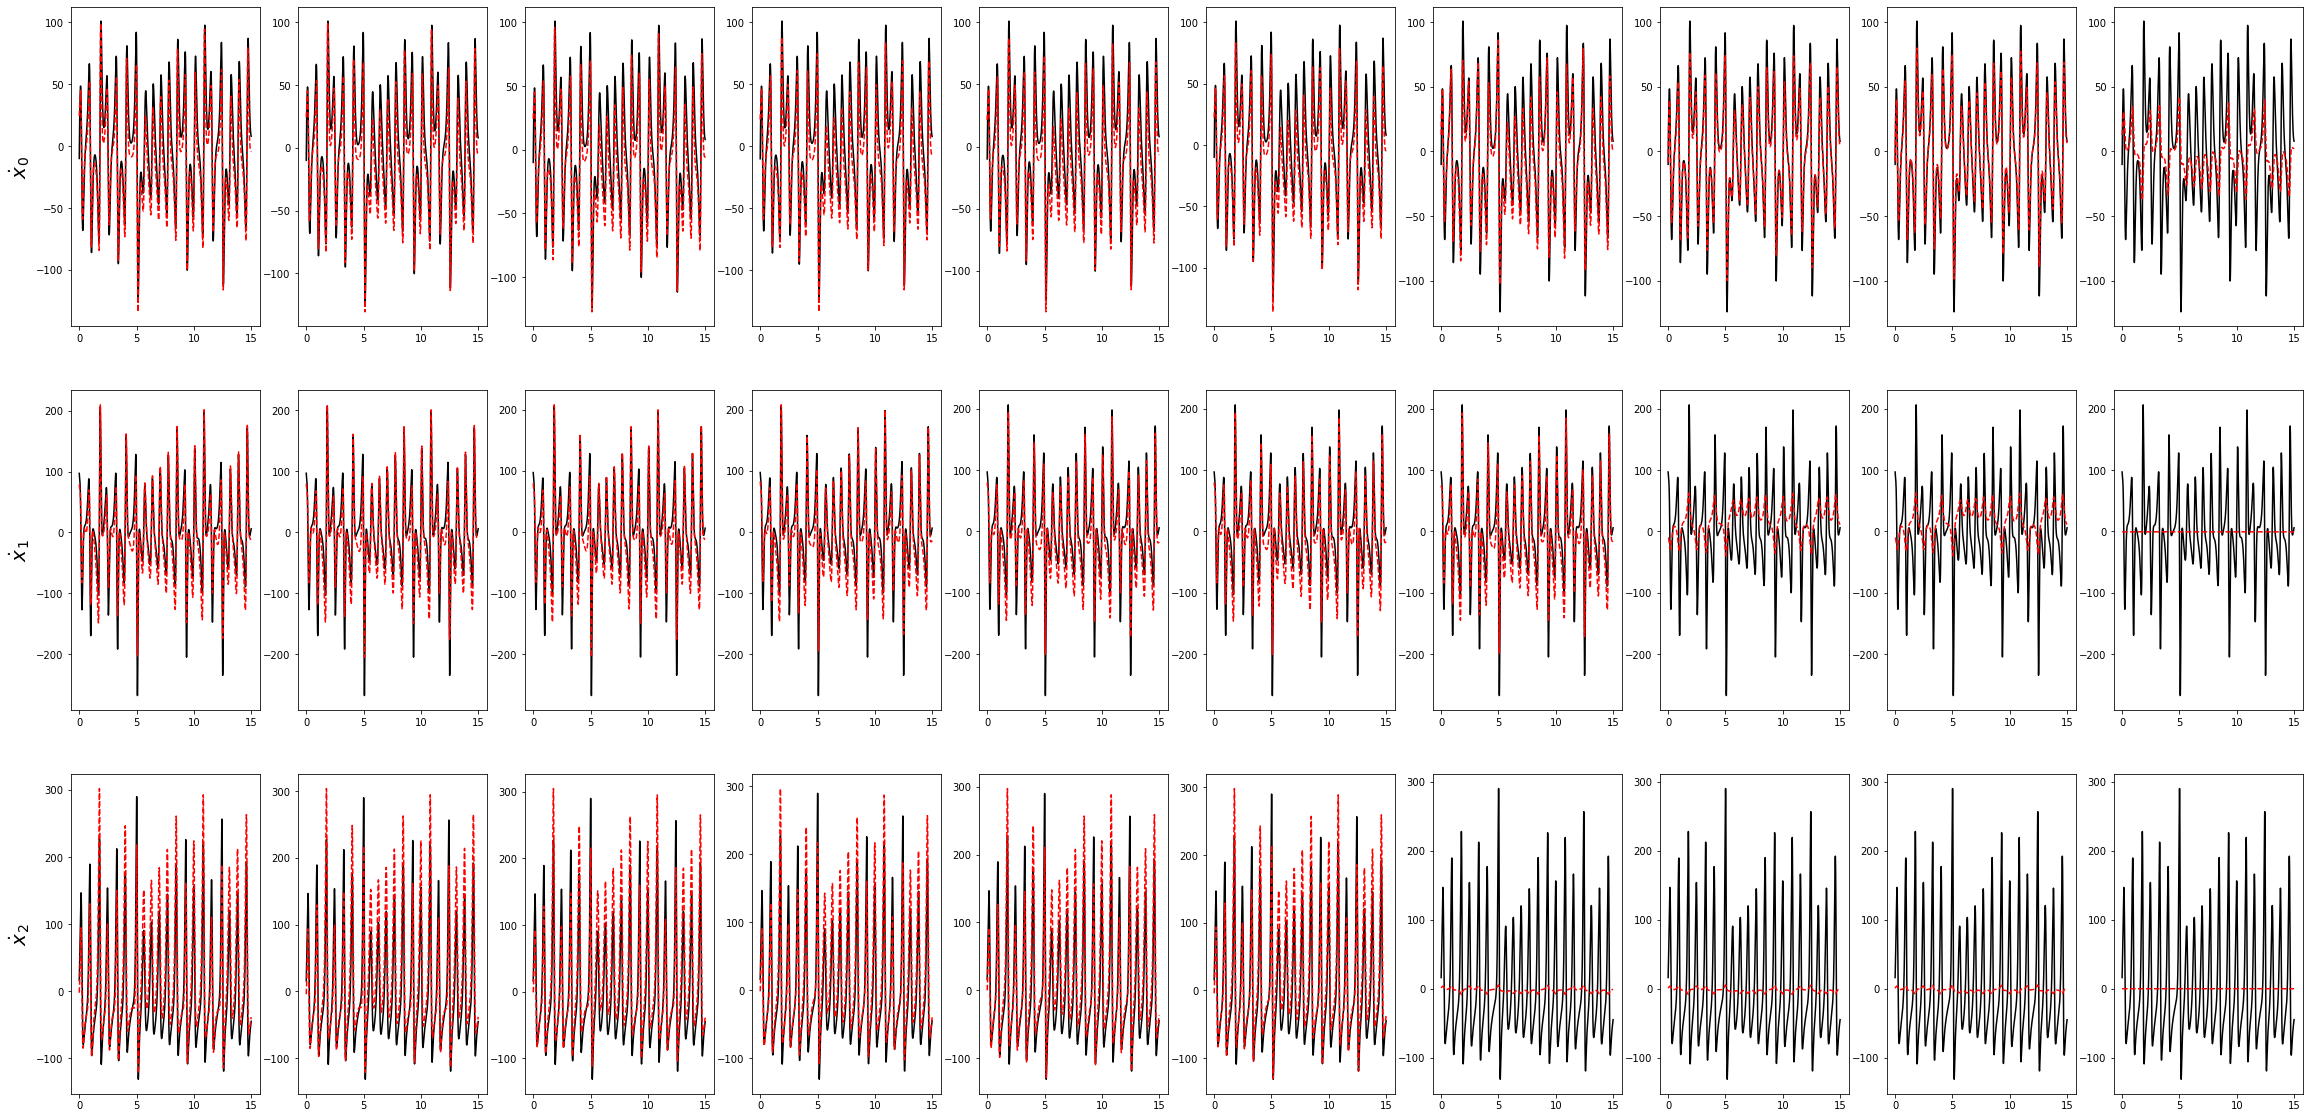

In [3]:
from sklearn.metrics import mean_squared_error

# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

plt.figure(figsize=(40, 20))
for j in range(np.shape(ssr_optimizer.history_)[0]):
    ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
    
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(x_test)  

    # Compute derivatives with a finite difference method, for comparison
    x_dot_test_computed = model.differentiate(x_test, t=dt)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(ssr_optimizer.history_)[0], 
                    i * np.shape(ssr_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_dot_test_computed[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_dot_test_predicted[:, i],
                    'r--', label='model prediction')
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i), fontsize=20)
            
    print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


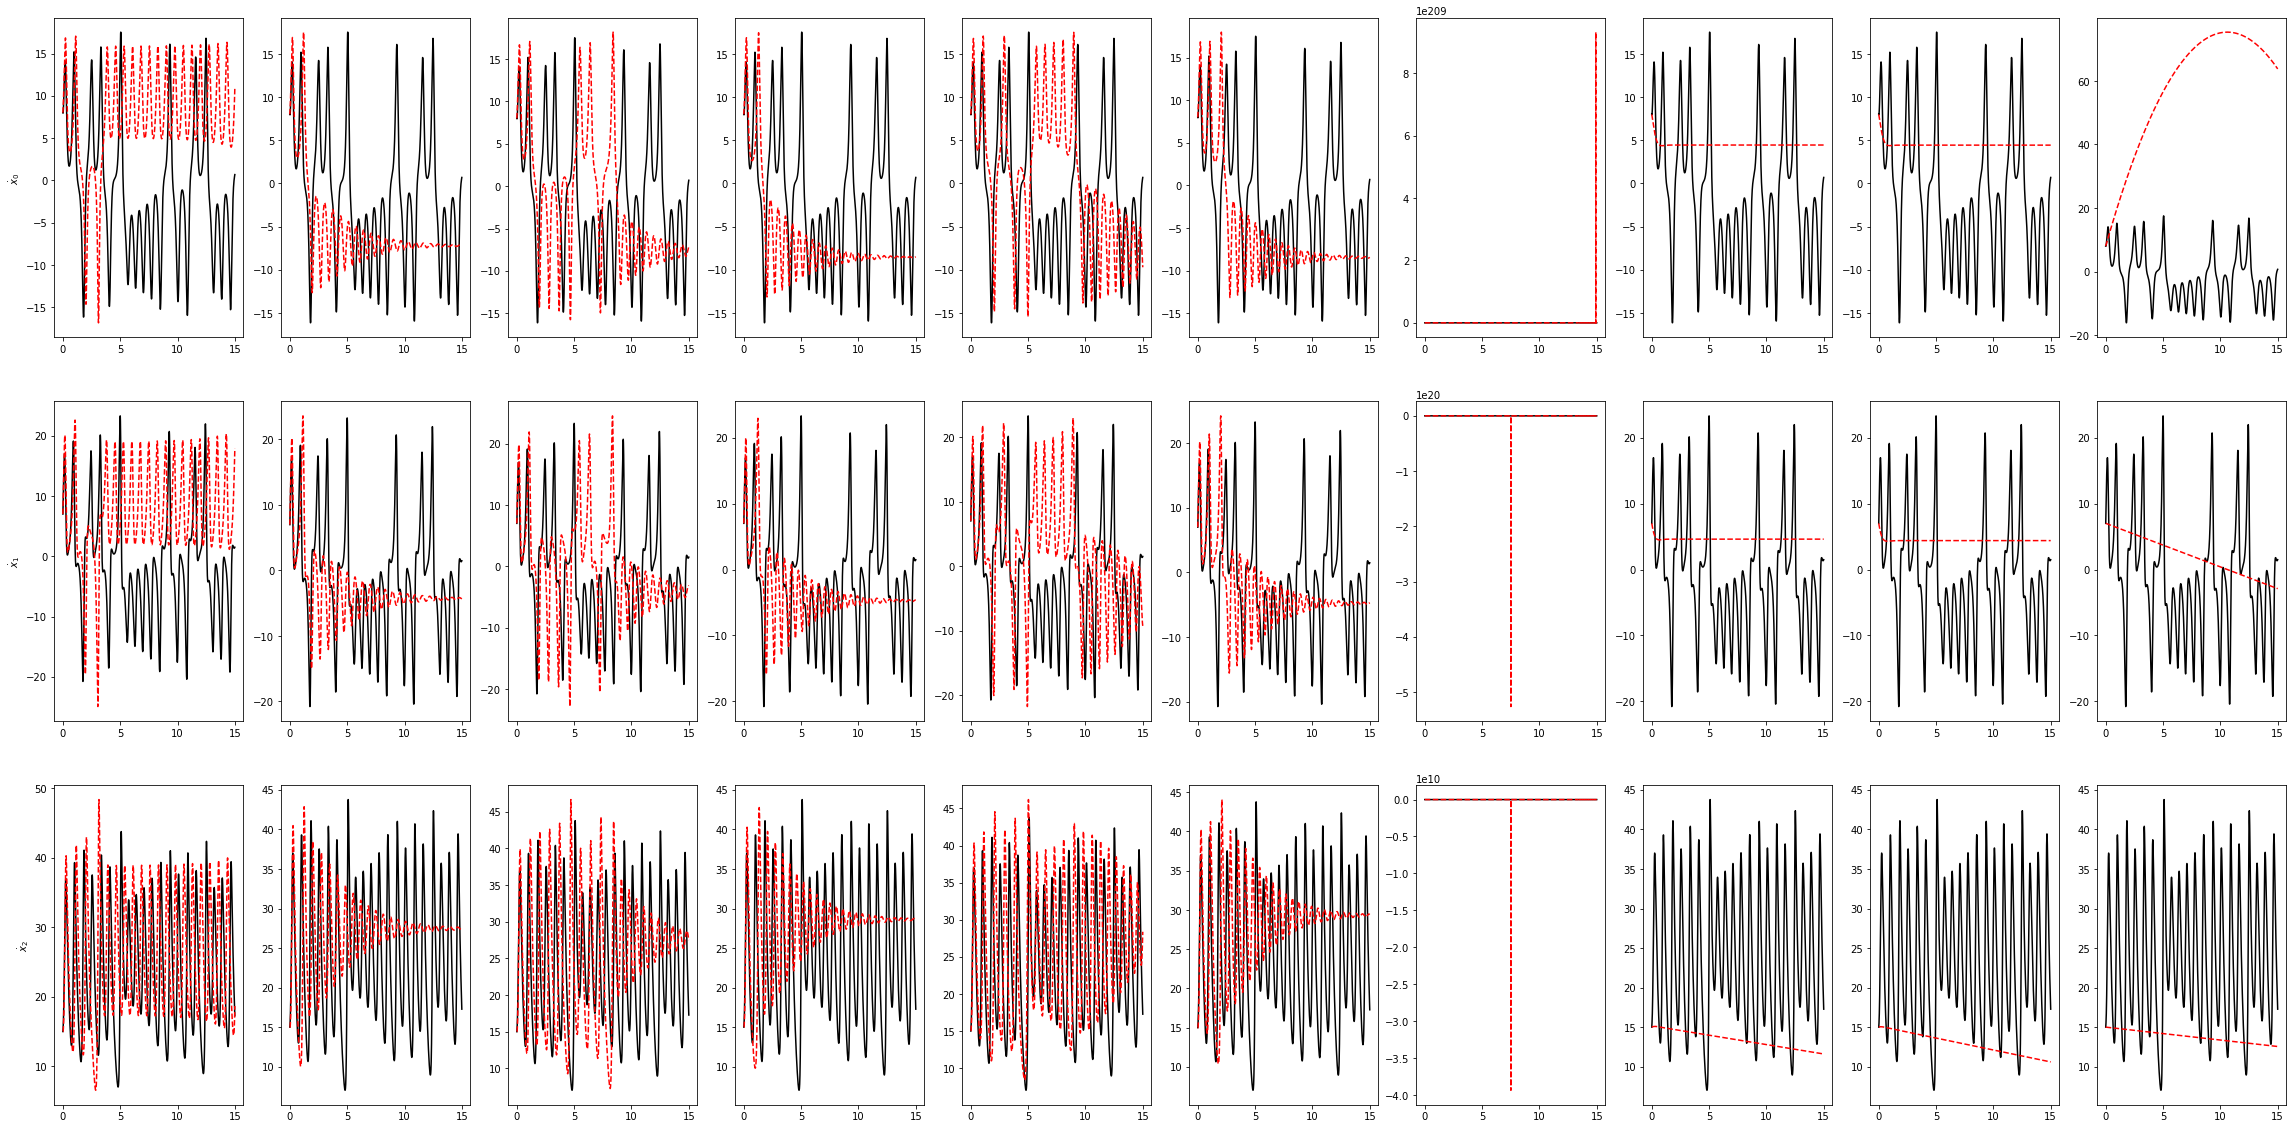

In [4]:
plt.figure(figsize=(40, 20))
for j in range(np.shape(ssr_optimizer.history_)[0]):
    ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
    
    x_test_sim = model.simulate(x0_test, t_test)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(ssr_optimizer.history_)[0], 
                    i * np.shape(ssr_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_test[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_test_sim[:, i],
                    'r--', label='model prediction')  
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i))

# Repeat the exercise with the lowest model residual method

In [5]:
ssr_optimizer = ps.SSR(alpha=.05, criteria="model_residual")
model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0', 'x1', 'x2'],
      optimizer=SSR(criteria='model_residual'))

Model 0, MSE: 767.590197
Model 1, MSE: 757.043840
Model 2, MSE: 776.093403
Model 3, MSE: 746.462105
Model 4, MSE: 817.825575
Model 5, MSE: 965.220761
Model 6, MSE: 944.442400
Model 7, MSE: 763.186358
Model 8, MSE: 320.746486
Model 9, MSE: 2577.308874


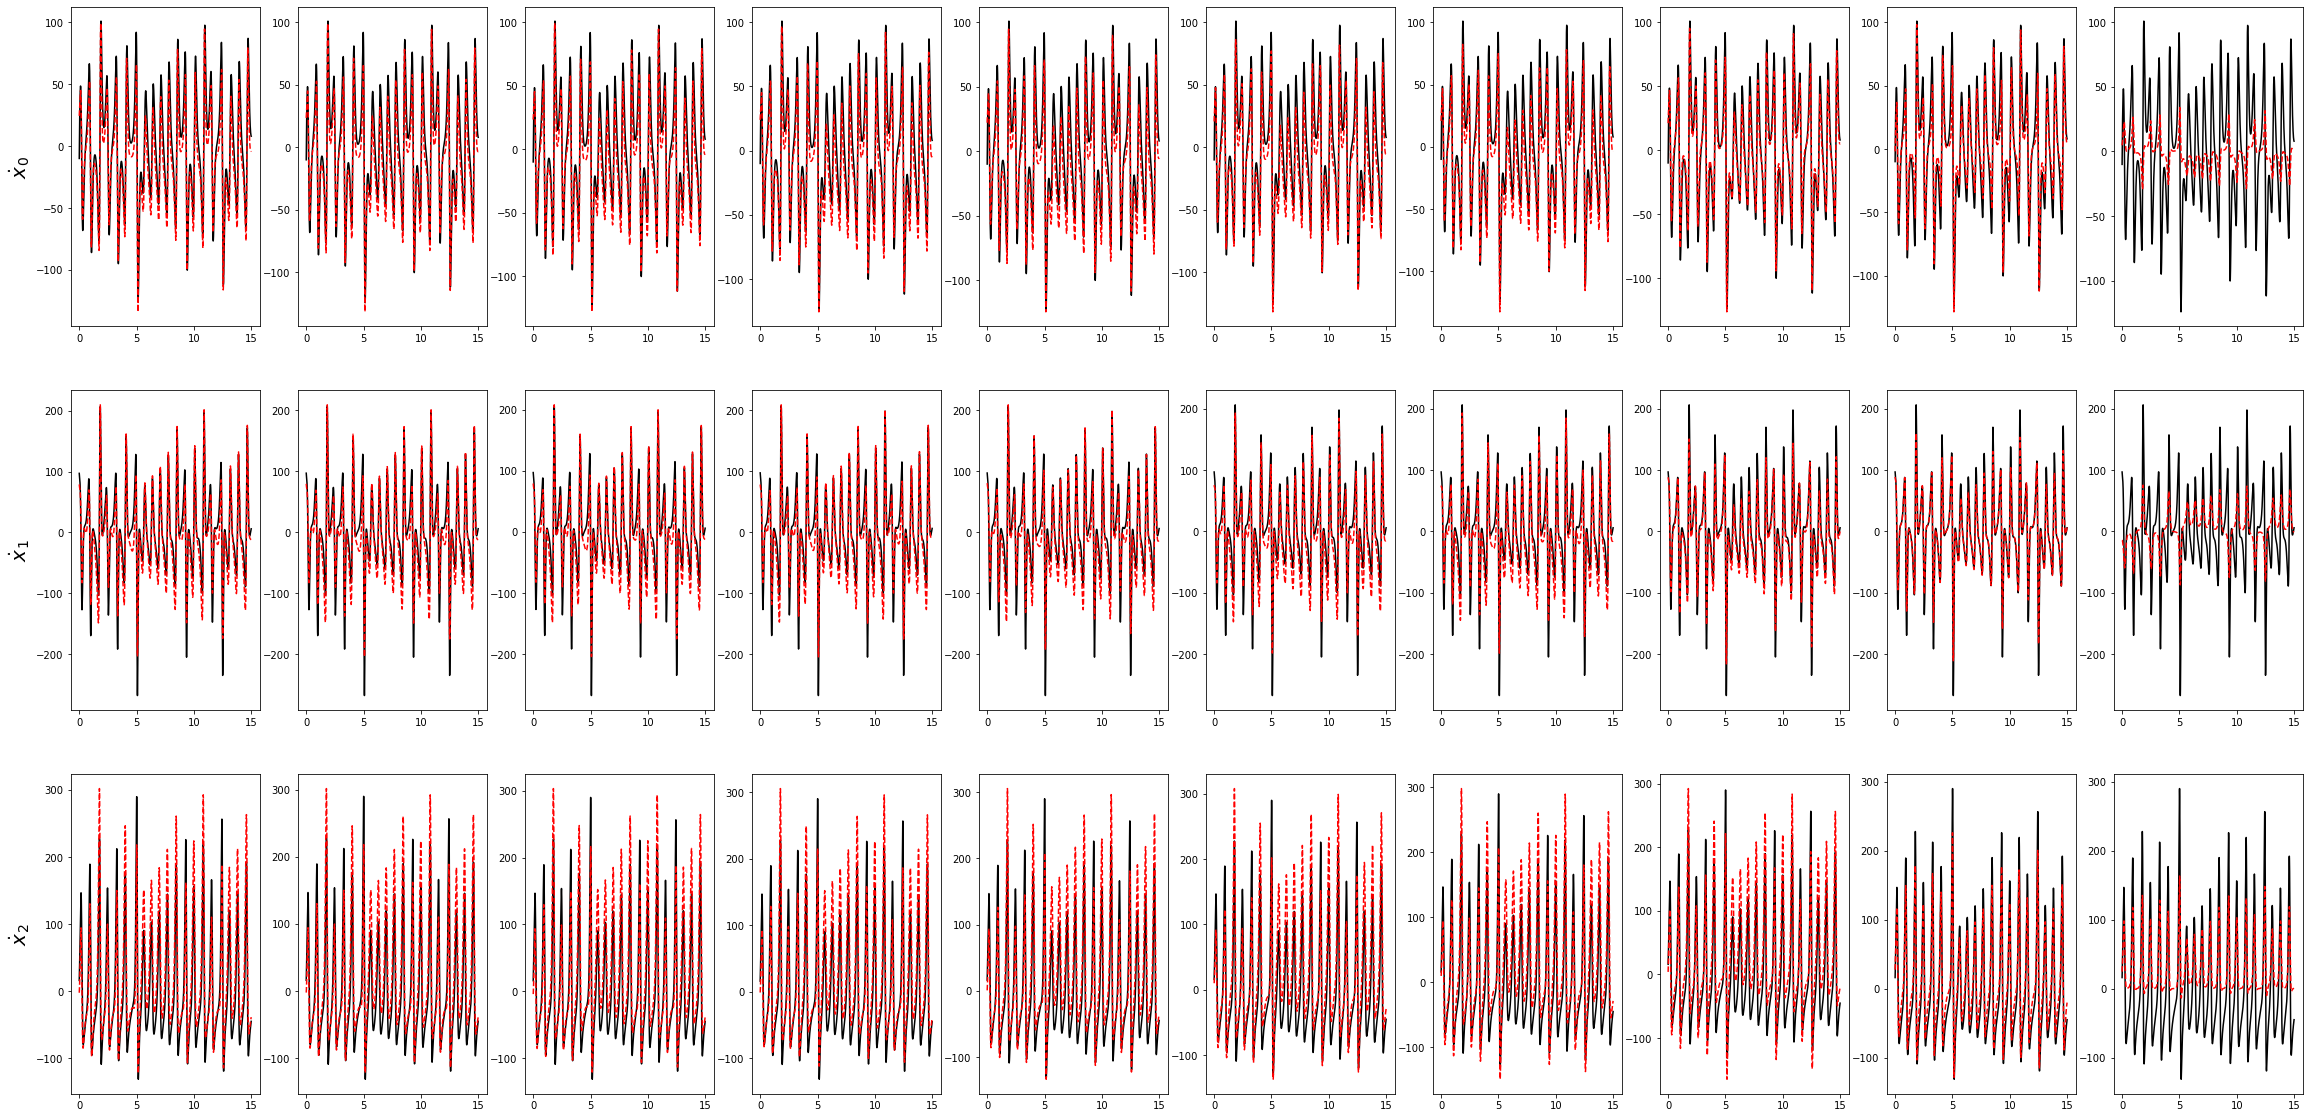

In [6]:
plt.figure(figsize=(40, 20))
for j in range(np.shape(ssr_optimizer.history_)[0]):
    ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
    
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(x_test)  

    # Compute derivatives with a finite difference method, for comparison
    x_dot_test_computed = model.differentiate(x_test, t=dt)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(ssr_optimizer.history_)[0], 
                    i * np.shape(ssr_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_dot_test_computed[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_dot_test_predicted[:, i],
                    'r--', label='model prediction')
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i), fontsize=20)
            
    print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))

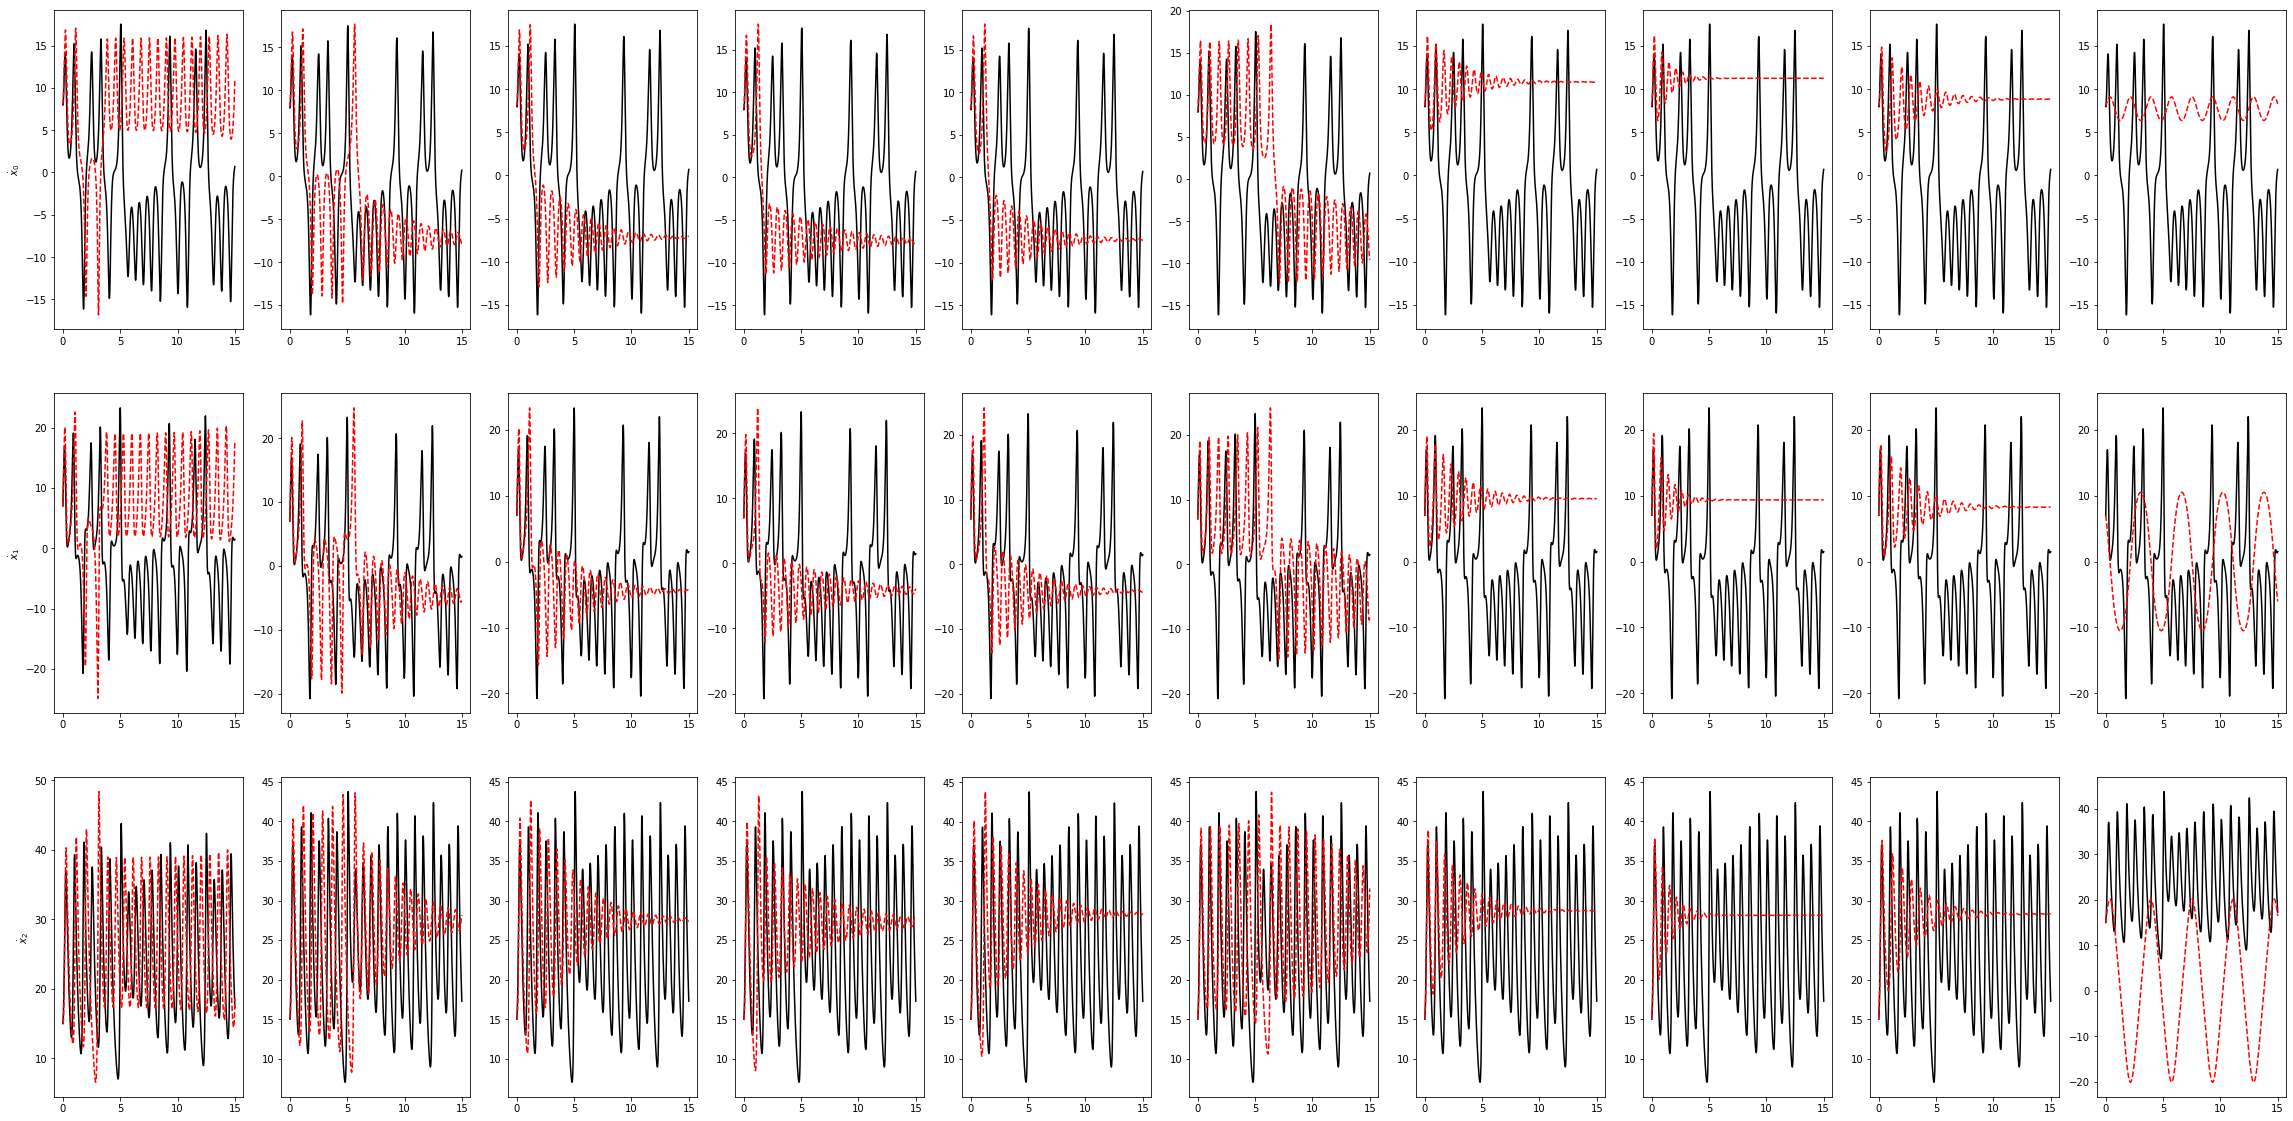

In [7]:
plt.figure(figsize=(40, 20))
for j in range(np.shape(ssr_optimizer.history_)[0]):
    ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
    
    x_test_sim = model.simulate(x0_test, t_test)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(ssr_optimizer.history_)[0], 
                    i * np.shape(ssr_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_test[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_test_sim[:, i],
                    'r--', label='model prediction')  
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i))

# Let's compare both methods as the noise steadily increases, cross-validated over 20 noise instantiations

In [8]:
dt = .01
t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
ssr_optimizer = ps.SSR(alpha=.05)
model = ps.SINDy(optimizer=ssr_optimizer)

t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

n_validation = 20
noise_levels = [0.02, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8]
criterias = ["coefficient_value", "model_residual"]
final_MSE = np.zeros((2, len(noise_levels), n_validation))
for k, noise_level in enumerate(noise_levels):
    for i in range(n_validation):
        x_noisy = x_train + np.random.rand(x_train.shape[0], 3) * noise_level
        for kk, criteria in enumerate(criterias): 
            ssr_optimizer = ps.SSR(alpha=.05, criteria=criteria)
            model = ps.SINDy(optimizer=ssr_optimizer)
            model.fit(x_noisy, t=dt)
            MSE = np.zeros(np.shape(ssr_optimizer.history_)[0])
            for j in range(np.shape(ssr_optimizer.history_)[0]):
                ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
                MSE[j] = model.score(x_test, t=dt, metric=mean_squared_error)
            final_MSE[kk, k, i] = np.min(MSE)

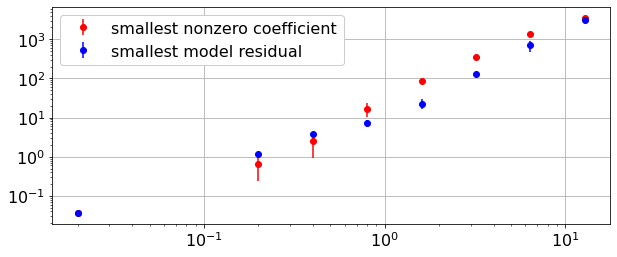

In [9]:
average_MSE_cross_validated = np.mean(final_MSE, axis=-1)
std_MSE_cross_validated = np.std(final_MSE, axis=-1)
plt.figure(figsize=(10, 4))
plt.errorbar(noise_levels, average_MSE_cross_validated[0, :], 
             yerr=std_MSE_cross_validated[0, :], fmt='o', color='r', 
             label='smallest nonzero coefficient')
plt.errorbar(noise_levels, average_MSE_cross_validated[1, :], 
             yerr=std_MSE_cross_validated[1, :], fmt='o', color='b',
             label='smallest model residual')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=16, loc='upper left', framealpha=1.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
ax.set_xticks([0.1, 1.0, 10])
plt.savefig('SSR_comparison.png')